# First import pytorch requirements

Usually you important everything at the top of your python file or jupyter notebook but I have explanations as we go through this and only import the minimum requirements.

In [1]:
# pytorch library
import torch

# Load MNIST and verify

In [2]:
# torchvision is a computer vision library that pytorch created for common datasets
# https://pytorch.org/docs/stable/torchvision
import torchvision
# import MNIST loader
from torchvision.datasets import MNIST

# https://pytorch.org/docs/stable/torchvision/datasets.html#mnist
# torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)
mnist_train_data = MNIST('data', train=True, download=True)

print("Number of training examples:", len(mnist_train_data))
print("Each with one image and one ground truth (gt) label:", len(mnist_train_data[0]))

print("One image and one label (number)")
print(mnist_train_data[0][0])
print(mnist_train_data[0][1])

print("Lets take a look at the image size")
print(mnist_train_data[0][0].size)

print("Lastly let's verify that the image and gt label match")
import matplotlib.pyplot as plt

img, label = mnist_train_data[0]

fig = plt.figure(figsize=(1,1))
ax1 = fig.add_subplot(1,1,1)
plt.title(label)
ax1.imshow(img, cmap="gray")

0it [00:00, ?it/s]

9920512it [00:04, 2053126.81it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 53075.95it/s]            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:01, 1226034.07it/s]                             
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 31556.31it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!
Number of training examples: 60000
Each with one image and one ground truth (gt) label: 2
One image and one label (number)
<PIL.Image.Image image mode=L size=28x28 at 0x7FEE6C685F10>
5
Lets take a look at the image size
(28, 28)
Lastly let's verify that the image and gt label match


# Create training transform and data loader

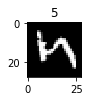

In [3]:
# import data transforms
# https://pytorch.org/docs/stable/torchvision/transforms.html
# Take note of transforms.ToPILImage and transforms.ToTensor
import torchvision.transforms as transforms

# We want to give our neural network more exmaples. What transforms make sense for this data?
# ColorJitter? Nope, the number is black and white
# Crop or Flip? Nope, that could remove parts of the number or make it unreadable
# RandomRotation? Yes, numbers can be slightly slanted
# Normalize? Yes, you should always normalize

mnist_train_tf = transforms.Compose([
    transforms.RandomRotation([-10, 10]),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Supplied with dataset (mean, std)
])

# Let's test out the transform (without toTensor)
img_tfed = transforms.RandomRotation([90, 90])(img)
# Display the image
fig = plt.figure(figsize=(1,1))
ax1 = fig.add_subplot(1,1,1)
plt.title(label)
ax1.imshow(img_tfed, cmap="gray")

# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
from torch.utils.data import DataLoader

# reimport MNIST with transform
mnist_train_data_transformed = MNIST('data', train=True, download=True, transform=mnist_train_tf)

# epoch = one iteration over the entire dataset
# batch size = samples per batch within an epoch
# shuffle = Set to True if your data is ordered
# num_workers = number of subprocess to use when dataloading, set higher if you have many cpu cores
train_loader = DataLoader(mnist_train_data_transformed, batch_size=4, shuffle=True, num_workers=2)

# Important concepts to remember before creating the neural network

Kernel - Convolution: https://en.wikipedia.org/wiki/Kernel_(image_processing)#Convolution
- Weighted sum around a pixel
- nn.Conv2d(in_channels, out_channels, kernel_size, stride=1)
- nn.Conv2d(1, 32, 3, 1)

Activation functions:https://en.wikipedia.org/wiki/Activation_function
- Logistic - https://en.wikipedia.org/wiki/Logistic_function
- ReLU - https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

Pooling: https://pytorch.org/docs/stable/nn.functional.html#pooling-functions
- Downsample the feature map
- Notable pooling functions: average and max

Dropout: https://pytorch.org/docs/stable/nn.html#dropout-layers
- Promote independence between feature maps
- The dropout paper https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

Fully connected layers
- First flatten the tensor
- Goal is to classify the image based on given feature maps
- Eventual output is the number of classes

Final output layer
- We want each class index to have probability
- Can we use softmax? Takes vector and makes sum 1. https://pytorch.org/docs/stable/nn.html#torch.nn.Softmax no it has some issues with NLL loss https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/
- log softmax https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax


Visualizing and Understanding Convolutional Networks
https://arxiv.org/abs/1311.2901
- Lines -> Lines/Curves/Corners -> Patterns -> Objects

Even more detail:

http://cs231n.github.io/convolutional-networks/

https://en.wikipedia.org/wiki/Convolutional_neural_network#Design

# Create the neural network

In [4]:
# neural network layers (Conv2d, Linear, etc.) that will be trained
# https://pytorch.org/docs/stable/nn.html
import torch.nn as nn
# Many functions (convolution, pooling, activation, etc.)
# https://pytorch.org/docs/stable/nn.functional.html
import torch.nn.functional as F

# This NN implementation is from the pytorch github
# https://github.com/pytorch/examples/blob/master/mnist/main.py

# all nn layers defined and stored in vars within __init__
# https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # comments were created by: print(x.shape)
        # initial x shape: torch.Size([4, 1, 28, 28])
        # 4 = batch_size
        # 1 = number of channels (Greyscale will have 1, RGB with have 3)
        # 28 = height
        # 28 = width
        x = self.conv1(x)       # torch.Size([4, 32, 26, 26])
        x = F.relu(x)           # torch.Size([4, 32, 26, 26])
        x = self.conv2(x)       # torch.Size([4, 64, 24, 24])
        x = F.max_pool2d(x, 2)  # torch.Size([4, 64, 12, 12])
        x = self.dropout1(x)    # torch.Size([4, 64, 12, 12])
        x = torch.flatten(x, 1) # torch.Size([4, 9216])
        x = self.fc1(x)         # torch.Size([4, 128])
        x = F.relu(x)           # torch.Size([4, 128])
        x = self.dropout2(x)    # torch.Size([4, 128])
        x = self.fc2(x)         # torch.Size([4, 10])
        output = F.log_softmax(x, dim=1) # torch.Size([4, 10])
        return output

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# Overide device when testing on CPU
# device = 'cpu'

net = Net().to(device)

# Define loss function and optimizer

In [13]:
# Various optimization algorithms are in:
# https://pytorch.org/docs/stable/optim.html
import torch.optim as optim


# NLLLoss is used when you expect 1 of N classes
# https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html
criterion = nn.NLLLoss()

# Stochastic Gradient Descent
# https://pytorch.org/docs/stable/optim.html#torch.optim.SGD
# torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)
# lr is the learning rate, how much to change weights based on current values
# momentum will change how much to change weights based on previous changes
# https://www.quora.com/What-is-the-difference-between-momentum-and-learning-rate
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Define Training loop

In [14]:
for epoch in range(4):  # loop over the dataset twice

    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch_idx % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch_idx + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.658
[1,  4000] loss: 0.257
[1,  6000] loss: 0.205
[1,  8000] loss: 0.167
[1, 10000] loss: 0.160
[1, 12000] loss: 0.134
[1, 14000] loss: 0.146
[2,  2000] loss: 0.131
[2,  4000] loss: 0.117
[2,  6000] loss: 0.107
[2,  8000] loss: 0.109
[2, 10000] loss: 0.104
[2, 12000] loss: 0.120
[2, 14000] loss: 0.106
[3,  2000] loss: 0.100
[3,  4000] loss: 0.097
[3,  6000] loss: 0.093
[3,  8000] loss: 0.090
[3, 10000] loss: 0.102
[3, 12000] loss: 0.104
[3, 14000] loss: 0.081
[4,  2000] loss: 0.084
[4,  4000] loss: 0.076
[4,  6000] loss: 0.078
[4,  8000] loss: 0.081
[4, 10000] loss: 0.078
[4, 12000] loss: 0.091
[4, 14000] loss: 0.081
Finished Training


# Create Test loader

In [15]:
# Test Data loading should not modify the image 
mnist_test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Supplied with dataset (mean, std)
])
mnist_test_data = MNIST('data', train=False, download=True, transform=mnist_test_tf)

test_loader = DataLoader(mnist_test_data, batch_size=4, shuffle=True, num_workers=2)

# Run Evaluation Loop

In [16]:
net.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = net(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.0351, Accuracy: 9885/10000 (99%)



# View some results

In [23]:
# Find one correctly classified and one misclassified

found_bad = False
found_good = False
bad_example = None
good_example = None

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = net(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        
        for i in range (0,len(target)):
            if not found_good and target[i] == pred[i]:
                good_example = transforms.ToPILImage()(data[i].cpu()), target[i].cpu().numpy(), pred[i][0].cpu().numpy()
                found_good = True
            if not found_bad and target[i] != pred[i]:
                bad_example = transforms.ToPILImage()(data[i].cpu()), target[i].cpu().numpy(), pred[i][0].cpu().numpy()
                found_bad = True
        
        if found_bad and found_good:
            break

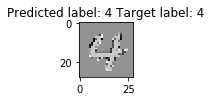

In [24]:
img, target_label, pred_label = good_example

fig = plt.figure(figsize=(1,1))
ax1 = fig.add_subplot(1,1,1)
plt.title("Predicted label: " + str(pred_label) + " Target label: " + str(target_label))
ax1.imshow(img, cmap="gray")

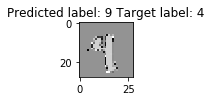

In [25]:
img, target_label, pred_label = bad_example

fig = plt.figure(figsize=(1,1))
ax1 = fig.add_subplot(1,1,1)
plt.title("Predicted label: " + str(pred_label) + " Target label: " + str(target_label))
ax1.imshow(img, cmap="gray")